In [1]:
%run "../../../common/0_notebooks_base_setup.py"   

/media/paulati/Nuevo vol/paula/dh/2021/dsad_2021_paula/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
nltk=3.5 already installed
unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


<img src='../../../common/logo_DH.png' align='left' width=35%/>

# Series de Tiempo - Práctica Guiada

<a id="section_toc"></a> 
## Tabla de Contenidos

[1- Modelos de ciclos para series de tiempo](#section_modelos_ciclos)

$\hspace{.5cm}$[1.1- Series Estacionarias](#section_series_estacionarias)

$\hspace{.5cm}$[1.2- Modelo ARIMA](#section_modelo_arima)

---

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

### Preparación del dataset

Vamos a leer el dataset usado en la clase anterior, lo preparamos y aplicamos nuevamente el modelo de Transformación logarítmica + estacionalidad mensual.

Luego lo usaremos para trabajar los nuevos modelos.

In [3]:
# Leemos el dataset y generamos nuevas variables
df = pd.read_csv('../Data/a10.csv', parse_dates=['date'], index_col='date')
df["timeIndex"] = pd.Series(np.arange(len(df['value'])), index=df.index)
df['log_value'] = np.log(df['value'])

df['month'] = [d.strftime('%b') for d in df.index]
dummies_mes = pd.get_dummies(df['month'])
df = df.join(dummies_mes)

In [4]:
df.head(3)

,value,timeIndex,log_value,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
date,,,,,,,,,,,,,,,,
1991-07-01,3.526591,0,1.260332,Jul,0,0,0,0,0,1,0,0,0,0,0,0
1991-08-01,3.180891,1,1.157161,Aug,0,1,0,0,0,0,0,0,0,0,0,0
1991-09-01,3.252221,2,1.179338,Sep,0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
# Dividimos en train y test
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=12, random_state=42, shuffle=False)

In [6]:
model_log_est = smf.ols('log_value ~ timeIndex + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = df_train).fit()

In [7]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex", \
                                              "Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex", \
                                              "Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])

In [8]:
# Recuperamos el valor predicho aplicando la función exponencial sobre las predicciones.
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

<a id="section_modelos_ciclos"></a> 
###  1- Modelos de Ciclos para Series de Tiempo
[volver a TOC](#section_toc)

Vamos ahora a modelar la **componente cíclica** de las series de tiempo. 

Recordemos que podíamos descomponer a una serie de tiempo de la siguiente manera:

$$ y_t = T_t + S_t + C_t + \varepsilon_t. $$

Por **ciclos** se entiende cualquier tipo de dinámica no capturada por la tendencia o la estacionalidad.

Estamos ante la presencia de ciclos cuando observamos algún tipo de dinámica mediante la cual el presente está vinculado al pasado. No tiene por qué ser un ciclo rígido.

Los ciclos son más complejos de analizar que la tendencia y la estacionalidad.

<a id="section_series_estacionarias"></a> 
#### 1.1- Series Estacionarias
[volver a TOC](#section_toc)

Solamente podemos trabajar con ciclos si tenemos series estacionarias. Comencemos por definir qué es una **serie estacionaria en sentido débil** o **estacionaria en la covarianza**:

$$ 1)\hspace{1cm}E(y_t) = \mu,  \forall t. $$
$$ 2)\hspace{1cm}Var(y_t) = \gamma < \infty,  \forall t. $$
$$ 3)\hspace{1cm}Cov(y_t, y_{t-k}) = \gamma_k < \infty,  \forall t,k. $$



1) Nos indica que la esperanza de $y_t$ es constante a lo largo del tiempo, es decir que no depende de t.

2) La varianza debe ser un valor constante y finito para todo t.

3) La autocovarianza es la covarianza de la variable contra sí misma en otros momentos del tiempo. Debe depender solamente de la traslación k y no de t.

Ejemplo de serie estacionaria:

<img src="img/Picture10.png" width="750">

Si bien la mayoría de las series no son estacionarias, es posible trabajar con modelos que tratan con los componentes no estacionarios (como el trend y la estacionalidad) de modo tal de que el componente cíclico remanente sea estacionario.

En el ejemplo de abajo, vemos que el residuo de la serie, una vez modelada la tendencia, es una serie estacionaria:

<img src="img/Picture7.png" width="450">

Alternativamente, podemos realizar transformaciones a nuestra serie para hacerla estacionaria. Podemos por ejemplo aplicar **diferenciaciones** de diferente orden para estabilizar la media o aplicar **transformaciones Box-Cox** para estabilizar la varianza. 

###### Test de Dickey-Fuller

Para evaluar la estacionariedad de una serie utilizamos el test de Dickey-Fuller (DF), o el test de Dickey-Fuller aumentado (ADF). 

•Si partimos del modelo $X_t = rX_{t-1} + u_t$

•Donde -1≤ r ≤ 1

•Si r=1 estamos en el caso de raíz unitaria y la serie no es estacioria (el Random Walk no es una series estacionaria).

•El test de Dickey-Fuller (DF) se basa en la siguiente regresión:
    $DX_t = dX_{t-1} + u_{t}$ , donde $d = (r-1)$

•La hipótesis nula $H_0$ es que los datos son no estacionarios 

•$H_0$ se rechaza si el estimador de d es negativo y significativamente diferente de cero.

En el DF se supone que el $u_t$ no está autocorrelacionado. El ADF contempla esta posibilidad adicionando al DF los valores rezagados de la variable dependiente. La $H_0$ es idéntica.

Vamos a calcular los resíduos del mejor modelo que tenemos hasta ahora, el modelo con transformación logarítmica y dummies estacionales.

Probamos primero si los residuos del modelo en la serie original son estacionarios:

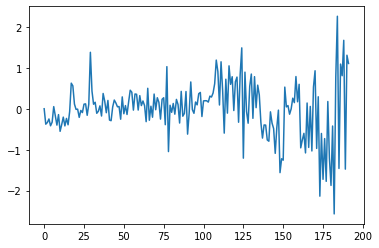

In [9]:
res_model = df_train['value'] - df_train['back_model_log_est']

plt.plot(df_train.timeIndex, res_model, '-');

Aplicamos el test de Dickey-Fuller al resíduo:

In [10]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -2.835097
p-value: 0.053433
Valor crítico 1%: -3.47
Valor crítico 5%: -2.88
Valor crítico 10%: -2.58


No podemos rechazar la $H_0$ con un nivel de significación del 5%. Probamos ahora con los residuos antes de realizar back transform:

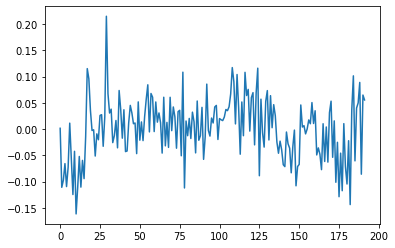

In [11]:
res_log_est = df_train['log_value'] - df_train['model_log_est']

plt.plot(df_train.timeIndex, res_log_est, '-');

In [12]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_log_est)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -4.559435
p-value: 0.000153
Valor crítico 1%: -3.47
Valor crítico 5%: -2.88
Valor crítico 10%: -2.57


Podemos rechazar la $H_0$. Avanzamos con el modelado de los ciclos de los residuos del modelo:

<a id="section_modelo_arima"></a> 
#### 1.2- Modelo ARIMA
[volver a TOC](#section_toc)

El modelo ARIMA sin estacionalidad surge por la combinación de:
* un modelo Auto-Regresivo AR(p), basado en la diferenciación o rezago de la serie y
* un modelo de media móvil MA(q).

Su denominación es producto de las siglas en inglés: **AutoRegressive Integrated Moving Average** model.

Veamos un mayor detalle de los dos modelos que componen ARIMA:

##### Modelos Auto-Regresivos - AR (p)

En un modelo de autorregresión, pronosticamos la variable de interés usando una combinación lineal de valores pasados de la variable en cuestión. El término autoregresión indica que es una regresión de la variable contra sí misma. Por lo tanto, un modelo de **orden autorregresivo (p)** se puede escribir como:

$$ y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + .. \\ $$
El Random Walk es un modelo AR (1) con $$ \phi_1 = 1,  c = 0 \\ $$ El Random Walk with drift (deriva) $$ \phi_1 = 1,  c \ != 0 \\ $$

Normalmente restringimos los modelos autorregresivos a datos estacionarios; también pueden ser necesarias algunas condiciones sobre los valores de los parámetros. Para un modelo AR (1), la condición de estacionariedad se determina como: $$ |\phi_1| < 1 $$.

##### Modelo de media móvil - MA (q)

En lugar de utilizar valores pasados de la variable a pronosticar mediante una regresión, un modelo de media móvil usa **shocks inobservables presentes y pasados** en un modelo similar a una regresión.

$$ y_t = c + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + ... + \theta_q e_{t-q} \\ $$

donde **$e$ es ruido blanco**. Nos referimos a esto como un modelo **MA (q)**, donde $q$ representa la **cantidad de rezagos** considerados en el modelo. Por supuesto, no observamos los valores de $ {e_t} $, por lo que no es realmente regresión en el sentido habitual.

Veamos que cada valor de $ {y_t} $ se puede considerar como una media móvil ponderada de los últimos errores de pronóstico. Sin embargo, los modelos basados en la media móvil no deben confundirse con el suavizado del promedio móvil. Se usa un modelo de promedio móvil para pronosticar valores futuros, mientras que el suavizado promedio móvil se usa para estimar el ciclo de tendencia de valores pasados.

##### Modelo ARIMA 

El modelo completo se puede escribir como:

* **Número de términos AR (autorregresivos) (p)**: los términos AR son solo rezagos de la variable dependiente. Por ejemplo, si *p* es 5, los predictores para  $ {y_t} $  serán  $ y_{t-1} $, $ y_{t-2} $  ... y  $ y_{t-5} $ .

* **Número de términos MA (promedio móvil) (q)**: los términos MA son errores de pronóstico rezagados en la ecuación de predicción. Por ejemplo, si *q* es 5, los predictores para $ {y_t} $ serán $ {e_t} $, $ e_{t-1} $, $ e_{t-2} $ ... $ e_{t-5} $ donde $ {e_t} $ es la diferencia entre el valor estimado y el valor instantáneo y real.

* **Número de diferencias (d)**: son las diferencias no estacionales que necesitamos para la estacionariedad. Entonces, o podemos pasar la variable diferenciada y poner d* = 0 o pasar la variable original y poner d* = d. Ambos generarán los mismos resultados.

Una preocupación importante aquí es cómo determinar el valor de *p* y *q*. Usamos dos vías para determinar estos parámetros, veamos:

* **Función de autocorrelación (ACF)**: es una medida de la correlación entre la serie y su rezago, también se conoce como la función de autocorrelación total. La ACF en el rezago *k*, denotada por $ \rho_k $, se define como:

$$ \rho_k = \frac {\gamma_k} {\gamma_0} $$

* **Función de autocorrelación parcial (PACF)**: mide la correlación entre la serie y su rezago después de eliminar las variaciones ya explicadas por las comparaciones intermedias. Por ejemplo, en el desfasaje 5, comprueba la correlación tras eliminar los efectos ya explicados por los rezagos 1 a 4.

En el modelo MA, el ruido (shock) se desvanece rápidamente con el tiempo. En sentido opuesto, el modelo AR tiene un efecto muy duradero del shock. De ahí que, mientras el primero se enfoca en períodos cortos de tiempo, el segundo prioriza el más largo plazo.

Importamos plots ACF y PACF:

In [13]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Calculamos la ACF para res_log con 20 rezagos:

In [14]:
lag_acf = acf(res_log_est, nlags = 20)
lag_acf

array([ 1.        ,  0.25331232,  0.3278516 ,  0.33542221,  0.16056543,
        0.17685594,  0.18348985,  0.12612221,  0.11293057,  0.19384455,
        0.06273299,  0.09339021,  0.24667848, -0.01767215,  0.10993571,
       -0.02582867, -0.02869637, -0.0445546 ,  0.0131938 , -0.05754254,
       -0.0013053 ])

Almacenamos la ACF en una Serie de Pandas y la ploteamos:

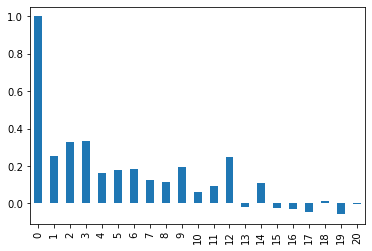

In [15]:
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

Calculamos la PACF para res_log con 20 rezagos. Usamos mínimos cuadrádos ordinarios para estimar los parámetros:

In [16]:
lag_pacf = pacf(res_log_est, nlags=20, method='ols');

Almacenamos la PACF en una Serie de Pandas y la ploteamos:

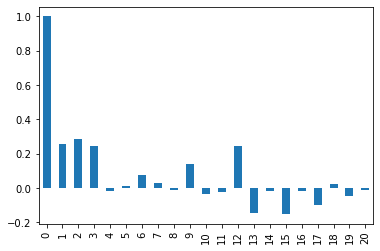

In [17]:
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar");

Vamos a definir una función que va a plotear una serie y nos va a dar información sobre su estacionariedad y sobre sus ACF y PACF:

In [18]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

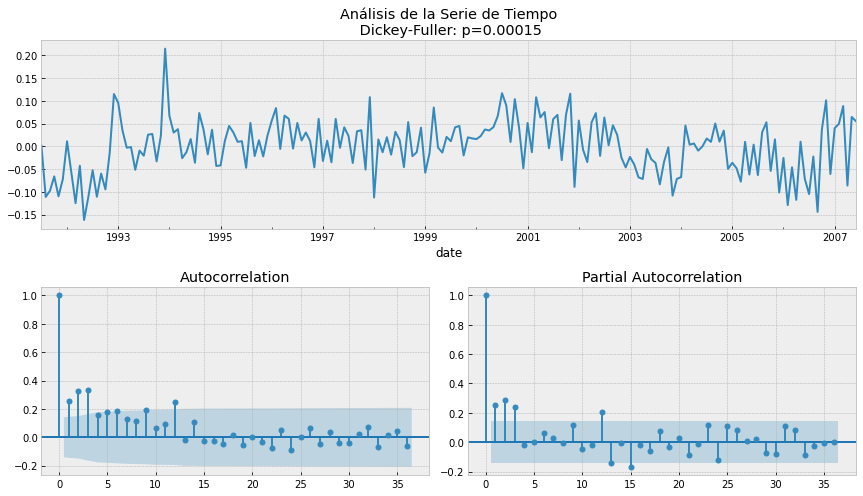

In [19]:
# Corremos la función con nuestra serie res_log:

tsplot(res_log_est, lags=36)

Vemos que el gráfico nos sugiere valores para $p$ y para $q$. 

En este caso tenenemos: $p = 3$ y $q = 3$:

In [20]:
# Importamos el modelo ARIMA de statsmodels

from statsmodels.tsa.arima_model import ARIMA

Instancio el modelo con parámetros ($p=3$, $d=0$, $q=3$) según el análisis de ACF y PACF.

En este caso $d=0$ porque trabajamos directamente con una serie estacionaria. 

In [21]:
model_ARIMA = ARIMA(res_log_est, order=(3,0,3))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

date
1991-07-01   -0.001088
1991-08-01   -0.000413
1991-09-01   -0.022522
1991-10-01   -0.037477
1991-11-01   -0.054344
dtype: float64

Hacemos un print de los resultados:

In [22]:
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  192
Model:                     ARMA(3, 3)   Log Likelihood                 295.890
Method:                       css-mle   S.D. of innovations              0.051
Date:                Tue, 27 Jul 2021   AIC                           -575.779
Time:                        15:08:11   BIC                           -549.720
Sample:                    07-01-1991   HQIC                          -565.225
                         - 06-01-2007                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.012     -0.094      0.925      -0.024       0.022
ar.L1.y        0.0964      0.064      1.506      0.132      -0.029       0.222
ar.L2.y       -0.2360      0.051     -4.628      0.0

Vemos que el coeficiente ma.L1 no es significativo, pero como los rezagos de orden mayor sí lo son, dejamos los 3 coeficientes en el modelo. 

Ploteamos la serie res_log_est y las estimaciones del modelo:

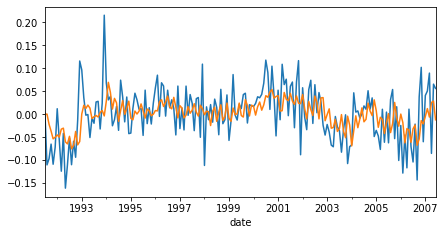

In [23]:
plt.figure(figsize=(7,3.5))
res_log_est.plot()
results_ARIMA.fittedvalues.plot();

Aplicamos el método plot_predict():

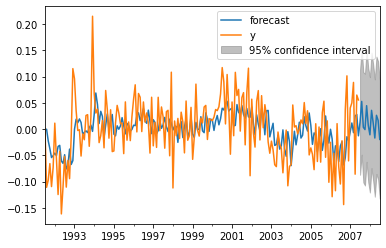

In [24]:
results_ARIMA.plot_predict(end=len(df['value']));

Analizamos los residuos del modelo ARIMA:

In [25]:
res_ARIMA =  results_ARIMA.fittedvalues - res_log_est

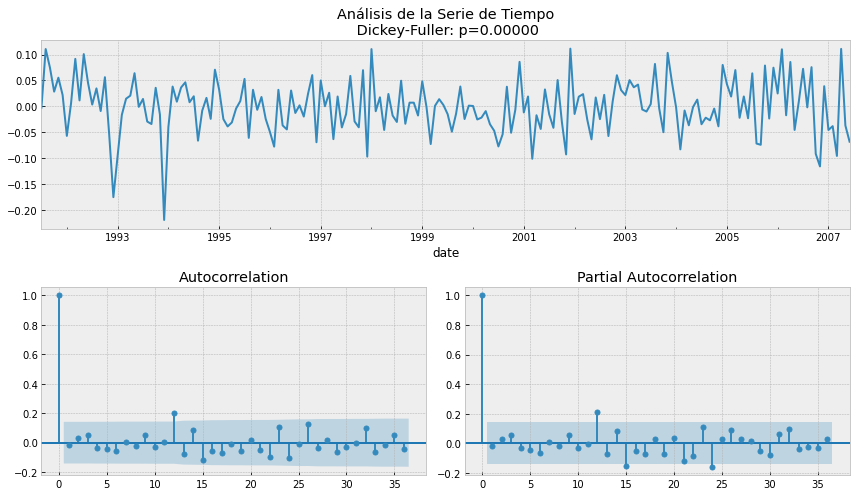

In [26]:
tsplot(res_ARIMA, lags=36)

No parecería haber más estructura en los resíduos que podamos capturar. Nuestro resíduo ahora es ruido blanco.

Con el método forecast() podemos hacer predicciones out-of-sample:

In [27]:
predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test['value']), alpha=0.05)

Incorporamos el efecto cíclico a nuestro modelo, sin realizar back-transformation:

In [28]:
df_train['log_model_ARIMA'] = df_train['model_log_est'] + results_ARIMA.fittedvalues

df_test['log_model_ARIMA'] = df_test['model_log_est'] + predictions_ARIMA

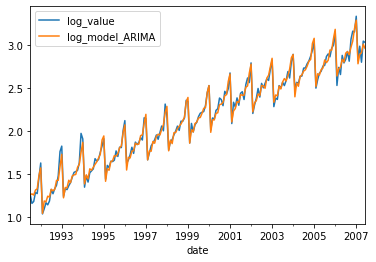

In [29]:
df_train.plot(kind = "line", y = ['log_value', 'log_model_ARIMA']);

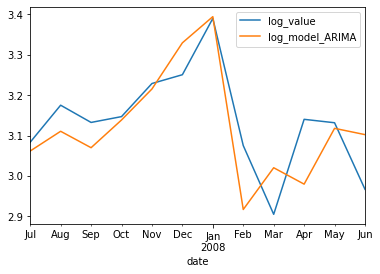

In [30]:
df_test.plot(kind = "line", y = ['log_value', 'log_model_ARIMA']);

Realizamos back-transformation al modelo logarítmico:

In [31]:
df_train['back_log_model_ARIMA'] = np.exp(df_train['log_model_ARIMA'])

df_test['back_log_model_ARIMA'] = np.exp(df_test['log_model_ARIMA'])

Ploteamos los resultados de la predicción con back-transformation en el set de train:

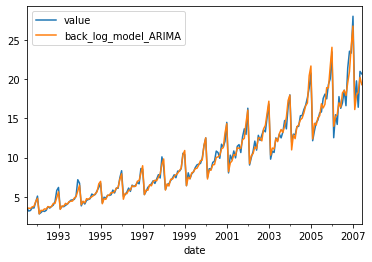

In [32]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_train.plot(kind = "line", y = ['value', 'back_log_model_ARIMA']);

Ploteamos los resultados de la predicción con back-transformation en el set de test:

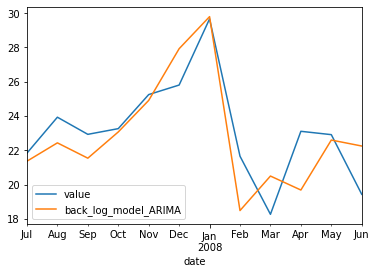

In [33]:
# POR FAVOR COMPLETÁ CON TU CÓDIGO:
df_test.plot(kind = "line", y = ['value', 'back_log_model_ARIMA']);

Calculamos el RMSE y lo almacenamos en nuestro DataFrame:

In [34]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [35]:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[7, "Model"] = "Log Model + est + ARIMA"
df_Results.loc[7, "RMSE"] = RMSE(df_test['back_log_model_ARIMA'], df_test['value'])
df_Results

,Model,RMSE
7,Log Model + est + ARIMA,1.91188


Vemos que el modelo que combina la tendencia, la estacionalidad y el ciclo es el que performa mejor de todos. 

<div id="caja7" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/en_resumen.png" style="align:left"/> </div>
  <br>
  <br>  
  <div style="float:left;width: 85%;"><label><b>En conclusión...</b></label></div>
</div>
<br>

Para modelar los ciclos usamos modelos ARIMA. Para modelar modelos ARIMA necesitamos que las series sean estacionarias. Las condiciones de estacionariedad son: 

$$ 1)\hspace{1cm}E(y_t) = \mu,  \forall t. $$
$$ 2)\hspace{1cm}Var(y_t) = \gamma < \infty,  \forall t. $$
$$ 3)\hspace{1cm}Cov(y_t, y_{t-k}) = \gamma_k < \infty,  \forall t,k. $$


Podríamos directamente comenzar a trabajar modelando los ciclos, sin pasar por la tendencia y la estacionalidad, pero en ese caso antes deberíamos asegurarnos de que la serie es estacionaria o realizar transformaciones para que lo sea, como por ejemplo diferenciar o aplicar transformaciones de Box-Cox.

###### Recordar que nuestro objetivo principal es que los resíduos de la serie sean ruido blanco, es decir que no quede más estructura en la serie que podamos extraer.

<div id="caja7" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/para_saber_mas.png" style="align:left"/> </div>
  <br>
  <br>  
  <div style="float:left;width: 85%;"><label><b>Para saber más:</b></label></div>
</div>
<br>

Pueden explorar dos recursos muy interesantes para trabajar con series de tiempo: Prophet y tsfresh:

[Prophet](https://github.com/facebook/prophet)

[tsfresh](https://tsfresh.readthedocs.io/en/latest/)

[volver a TOC](#section_toc)